In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from vae_earlystopping import EarlyStopping
from torch.utils.data import  DataLoader, Dataset
from model_vae import CVAE,cvae_loss_each,cvae_loss_optimized,cvae_loss
import pandas as pd
import matplotlib.pyplot as plt

x_data = np.load('./data/metal.npy',allow_pickle = True)
c_data = np.load('./data/reaction.npy',allow_pickle = True)
sup_data = np.load('./data/support.npy',allow_pickle=True)


In [ ]:
from sklearn.import

In [ ]:
## 페르브스카이트 취소
## 사이즈 맞나확인하기
## val_ shuffle하기
## minmax로 구하기
---
## learning_rate,batch_size,확인하기

In [6]:
from sklearn.model_selection import train_test_split
x_train,x_test,c_train,c_test = train_test_split(x_data,c_data,test_size= 0.4, shuffle=False)
x_val,x_test,c_val,c_test = train_test_split(x_test,c_test,test_size = 0.5, shuffle=False)
print(x_train.shape,x_val.shape,x_test.shape)

(3544, 24) (1182, 24) (1182, 24)


In [7]:
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler()
c_scaler = StandardScaler()
# x정규화
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.fit_transform(x_test)
x_val = x_scaler.fit_transform(x_val)
# c정규화
c_train = c_scaler.fit_transform(c_train)
c_val = c_scaler.transform(c_val)
c_test = c_scaler.transform(c_test)

In [8]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val   = torch.tensor(x_val,   dtype=torch.float32)
x_test  = torch.tensor(x_test,  dtype=torch.float32)

c_train = torch.tensor(c_train, dtype=torch.float32)
c_val   = torch.tensor(c_val,   dtype=torch.float32)
c_test  = torch.tensor(c_test,  dtype=torch.float32)

In [9]:
batch_size = 64
learning_rate = 0.01
from torch.utils.data import TensorDataset,DataLoader
train_data = TensorDataset(x_train,c_train)
val_data = TensorDataset(x_val,c_val)
test_data = TensorDataset(x_test,c_test)
train_loader = DataLoader(train_data,batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data,batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_data,batch_size = batch_size,shuffle = False)

In [10]:
x_dim = x_data.shape[1]
c_dim = c_data.shape[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(x_dim=x_dim,c_dim=c_dim,z_dim = 16).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [11]:
epochs = 200
train_losses = []
val_losses = []
early = EarlyStopping(patience=30, min_delta=1e-4)
for epoch in range(1,epochs+1):
    model.train()
    total_train_losses = 0.0
    for batch_x,batch_c in train_loader:
        batch_x = batch_x.to(device)
        batch_c = batch_c.to(device)
        optimizer.zero_grad()
        x_hat,mu,logvar = model(batch_x,batch_c)
        loss,recon,kl = cvae_loss(x_hat,batch_x,mu,logvar,beta = 0.01)
        loss.backward()
        optimizer.step()
        total_train_losses +=loss.item()
    avg_train_loss = total_train_losses/len(train_loader)
    #----검토
    model.eval()
    total_val_losses = 0.0
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x = v_x.to(device)
            v_c = v_c.to(device)
            v_x_hat,v_mu,v_logvar = model(v_x,v_c)
            v_loss,v_recon,v_kl = cvae_loss(v_x_hat,v_x,v_mu,v_logvar,beta = 0.01)
            total_val_losses = v_loss.item()
    avg_val_loss = total_val_losses/len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if epoch % 10 ==0 or epoch ==1:
        print(f"[{epoch}/{epochs}], train_losses:{avg_train_loss:.4f}, val_losses:{avg_val_loss:.4f}")
    stop = early.step(avg_val_loss,model)
    if early.best_state is not None and avg_val_loss == early.best:
        best_epoch = epoch
    if stop:
        print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch}, Best val loss: {early.best:.6f}")
        break



[1/200], train_losses:0.5559, val_losses:0.0397
[10/200], train_losses:0.2468, val_losses:0.0773
[20/200], train_losses:0.2889, val_losses:0.0603
[30/200], train_losses:0.2199, val_losses:0.0623
Early stopping at epoch 31. Best epoch: 1, Best val loss: 0.039722


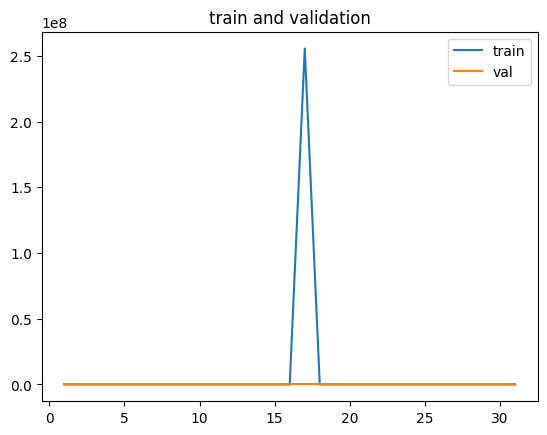

In [12]:
x = np.arange(1,epoch+1)
plt.plot(x,train_losses,label ='train')
plt.plot(x,val_losses,label = 'val')
plt.legend()
plt.title('train and validation')
plt.show()

## 최적의 모델을 찾기?

In [13]:
if early.best_state is not None:
    model.load_state_dict(early.best_state)
model = model.to(device)
model.eval()
with torch.no_grad():
    x_test = x_test.to(device)
    c_test = c_test.to(device)
    x_hat,mu,logvar = model(x_test,c_test)
    

In [14]:
x_true_test_np = x_test.detach().cpu().numpy()
x_test_np = x_hat.detach().cpu().numpy()
x_true_test = x_scaler.inverse_transform(x_true_test_np)
x_hat_test = x_scaler.inverse_transform(x_test_np)

In [15]:
df = pd.read_csv('211210-DRM-total.csv')
metal_columns = df.iloc[:,1:25].columns

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error

rmse = np.sqrt(mean_squared_error(x_true_test, x_hat_test))
mse = mean_squared_error(x_true_test,x_hat_test)
r2 = r2_score(x_true_test.flatten(),x_hat_test.flatten())
print(f'rmse: {rmse},r2: {r2}')

rmse: 1.3802468588388577,r2: 0.2907029390335083


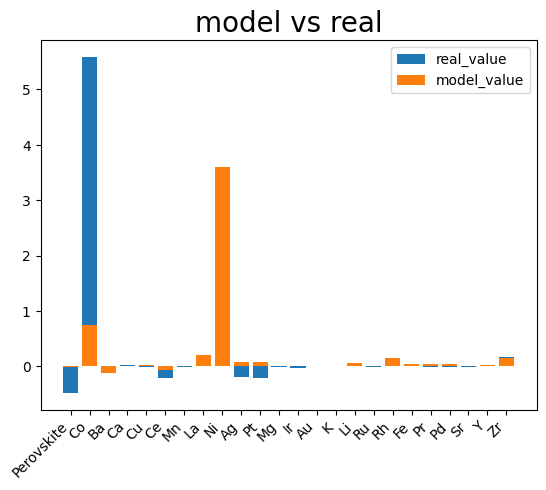

In [20]:
plt.bar(metal_columns, x_true_test[3],label = 'real_value')
plt.bar(metal_columns,x_hat_test[3],label = 'model_value')
plt.xticks(rotation=45,ha='right')
plt.title(f'model vs real',fontsize = 20)
plt.legend()
plt.show()